#**Analisis Sentimen Ulasan Aplikasi Livin**

##Import Library

In [523]:
!pip install numpy pandas nltk sastrawi scikit-learn

In [524]:
#Library untuk preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')


from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Load Data

In [525]:
df = pd.read_csv('/content/ulasan_livin.csv')

In [526]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  15765 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          17775 non-null  object
 9   repliedAt             17775 non-null  object
 10  appVersion            15765 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


#Data prep

In [527]:
#Cek missing value
print(df.isna().sum())

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    4235
at                         0
replyContent            2225
repliedAt               2225
appVersion              4235
dtype: int64


In [528]:
#Cek Duplikasi Data
print("Jumlah duplikasi data: ", df.duplicated().sum())

Jumlah duplikasi data:  0


Karena missing value terdapat pada kolom yang tidak diperlukan dalam analisis sentimen, maka kolom tersebut akan dibiarkan saja.

#Preprocessing Text

In [529]:
#Definisikan fungsi untuk preprocessing
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [530]:
#Definisikan slangwords agar diubah menjadi bentuk baku
slangwords = {
    "gg": "bagus", "mantul": "mantap betul", "kece": "keren", "sip": "baik", "ok": "oke",
    "okeh": "oke", "mayan": "lumayan", "zonk": "mengecewakan", "auto": "otomatis",
    "topup": "isi saldo", "withdraw": "tarik saldo", "saldo": "jumlah uang",
    "cashback": "pengembalian dana", "promo": "diskon", "voucher": "kupon diskon",
    "limit": "batas transaksi", "taptap": "tap kartu", "jeniuspay": "pembayaran Jenius",
    "m-card": "kartu utama", "e-card": "kartu virtual", "x-card": "kartu tambahan",
    "flexi": "fleksibel", "splitbill": "bagi tagihan", "paylater": "bayar nanti",
    "cashtag": "nama pengguna Jenius", "nomor rekening": "nomor akun", "mauin": "ingin",
    "lemot": "lambat", "delay": "tertunda", "bug": "kesalahan sistem", "error": "gagal",
    "crash": "berhenti mendadak", "otp": "kode verifikasi", "token": "kode keamanan",
    "update": "pembaruan", "upgrade": "peningkatan layanan", "downgrade": "penurunan layanan",
    "banned": "diblokir", "verif": "verifikasi", "respon": "tanggapan", "fastrespon": "tanggapan cepat",
    "slowrespon": "tanggapan lambat", "cs": "layanan pelanggan", "admin": "pengelola",
    "trusted": "terpercaya", "uninstall": "hapus aplikasi", "install": "pasang aplikasi",
    "subscribe": "berlangganan", "unsubscribe": "berhenti langganan"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [531]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [532]:
clean_df = df
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,64efb6b9-adf3-41b6-9699-11b1511ad12d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi kadang error tidak bisa di buka,2,0,2.2.0,2025-04-13 04:48:06,"Halo Sahabat @herman samarinda, mohon maaf ata...",2025-04-13 04:52:14,2.2.0
1,da619ef4-3db9-4b4c-b294-75c51baa8265,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa saya gk bisa buka mbeking saya setiap b...,3,0,2.2.0,2025-04-13 04:41:47,"Halo Sahabat @Bagus Azis, mohon maaf atas keti...",2025-04-13 04:49:25,2.2.0
2,bad7f93d-5b71-4462-976c-9de9655a6077,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,RIBET,1,0,2.2.0,2025-04-13 03:42:16,"Halo Sahabat @yayasan Jam'iyyatul muta'alimin,...",2025-04-13 04:18:11,2.2.0
3,f28ae28b-7f95-4910-b67d-4ab286a370b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,keren mandiri,5,0,2.2.0,2025-04-13 03:16:28,"Halo Sahabat @ADAM rijaldi, terima kasih atas ...",2025-04-13 03:19:16,2.2.0
4,a337b44f-e3c0-4773-bb66-89d144c05ce1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"ulangi pembuatan password, verifikasi wajah ga...",1,0,2.2.0,2025-04-13 01:59:33,"Halo Sahabat @Abdul Karim, mohon maaf atas\nke...",2025-04-13 03:27:30,2.2.0


In [533]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [534]:
#Dataset setelah preprocessing
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,64efb6b9-adf3-41b6-9699-11b1511ad12d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi kadang error tidak bisa di buka,2,0,2.2.0,2025-04-13 04:48:06,"Halo Sahabat @herman samarinda, mohon maaf ata...",2025-04-13 04:52:14,2.2.0,aplikasi kadang error tidak bisa di buka,aplikasi kadang error tidak bisa di buka,aplikasi kadang gagal tidak bisa di buka,"[aplikasi, kadang, gagal, tidak, bisa, di, buka]","[aplikasi, kadang, gagal, buka]",aplikasi kadang gagal buka
1,da619ef4-3db9-4b4c-b294-75c51baa8265,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa saya gk bisa buka mbeking saya setiap b...,3,0,2.2.0,2025-04-13 04:41:47,"Halo Sahabat @Bagus Azis, mohon maaf atas keti...",2025-04-13 04:49:25,2.2.0,kenapa saya gk bisa buka mbeking saya setiap b...,kenapa saya gk bisa buka mbeking saya setiap b...,kenapa saya gk bisa buka mbeking saya setiap b...,"[kenapa, saya, gk, bisa, buka, mbeking, saya, ...","[gk, buka, mbeking, buka]",gk buka mbeking buka
2,bad7f93d-5b71-4462-976c-9de9655a6077,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,RIBET,1,0,2.2.0,2025-04-13 03:42:16,"Halo Sahabat @yayasan Jam'iyyatul muta'alimin,...",2025-04-13 04:18:11,2.2.0,RIBET,ribet,ribet,[ribet],[ribet],ribet
3,f28ae28b-7f95-4910-b67d-4ab286a370b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,keren mandiri,5,0,2.2.0,2025-04-13 03:16:28,"Halo Sahabat @ADAM rijaldi, terima kasih atas ...",2025-04-13 03:19:16,2.2.0,keren mandiri,keren mandiri,keren mandiri,"[keren, mandiri]","[keren, mandiri]",keren mandiri
4,a337b44f-e3c0-4773-bb66-89d144c05ce1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"ulangi pembuatan password, verifikasi wajah ga...",1,0,2.2.0,2025-04-13 01:59:33,"Halo Sahabat @Abdul Karim, mohon maaf atas\nke...",2025-04-13 03:27:30,2.2.0,ulangi pembuatan password verifikasi wajah gag...,ulangi pembuatan password verifikasi wajah gag...,ulangi pembuatan password verifikasi wajah gag...,"[ulangi, pembuatan, password, verifikasi, waja...","[ulangi, pembuatan, password, verifikasi, waja...",ulangi pembuatan password verifikasi wajah gag...


#Pelabelan Data Menggunakan Lexicon

In [535]:
import requests
import csv
from io import StringIO

lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [536]:
#Menentukan orientasi sentimen dengan polarity score

def pelabelan_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity_score=''

    if (score >= 0):
        polarity_score = 'positive'
    elif (score <= -3):
        polarity_score = 'negative'
    else:
        polarity_score = 'neutral'

    return score, polarity_score

In [537]:
results = clean_df['text_stopword'].apply(pelabelan_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    11168
negative     6392
neutral      2440
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

In [538]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,64efb6b9-adf3-41b6-9699-11b1511ad12d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi kadang error tidak bisa di buka,2,0,2.2.0,2025-04-13 04:48:06,"Halo Sahabat @herman samarinda, mohon maaf ata...",2025-04-13 04:52:14,2.2.0,aplikasi kadang error tidak bisa di buka,aplikasi kadang error tidak bisa di buka,aplikasi kadang gagal tidak bisa di buka,"[aplikasi, kadang, gagal, tidak, bisa, di, buka]","[aplikasi, kadang, gagal, buka]",aplikasi kadang gagal buka,-5,negative
1,da619ef4-3db9-4b4c-b294-75c51baa8265,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa saya gk bisa buka mbeking saya setiap b...,3,0,2.2.0,2025-04-13 04:41:47,"Halo Sahabat @Bagus Azis, mohon maaf atas keti...",2025-04-13 04:49:25,2.2.0,kenapa saya gk bisa buka mbeking saya setiap b...,kenapa saya gk bisa buka mbeking saya setiap b...,kenapa saya gk bisa buka mbeking saya setiap b...,"[kenapa, saya, gk, bisa, buka, mbeking, saya, ...","[gk, buka, mbeking, buka]",gk buka mbeking buka,0,positive
2,bad7f93d-5b71-4462-976c-9de9655a6077,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,RIBET,1,0,2.2.0,2025-04-13 03:42:16,"Halo Sahabat @yayasan Jam'iyyatul muta'alimin,...",2025-04-13 04:18:11,2.2.0,RIBET,ribet,ribet,[ribet],[ribet],ribet,-4,negative
3,f28ae28b-7f95-4910-b67d-4ab286a370b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,keren mandiri,5,0,2.2.0,2025-04-13 03:16:28,"Halo Sahabat @ADAM rijaldi, terima kasih atas ...",2025-04-13 03:19:16,2.2.0,keren mandiri,keren mandiri,keren mandiri,"[keren, mandiri]","[keren, mandiri]",keren mandiri,-3,negative
4,a337b44f-e3c0-4773-bb66-89d144c05ce1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"ulangi pembuatan password, verifikasi wajah ga...",1,0,2.2.0,2025-04-13 01:59:33,"Halo Sahabat @Abdul Karim, mohon maaf atas\nke...",2025-04-13 03:27:30,2.2.0,ulangi pembuatan password verifikasi wajah gag...,ulangi pembuatan password verifikasi wajah gag...,ulangi pembuatan password verifikasi wajah gag...,"[ulangi, pembuatan, password, verifikasi, waja...","[ulangi, pembuatan, password, verifikasi, waja...",ulangi pembuatan password verifikasi wajah gag...,-13,negative


<ipython-input-539-57e1dfa8c585>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='polarity', data=clean_df, palette='Set1')


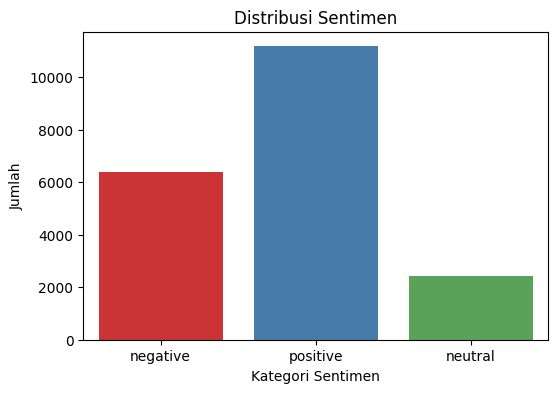

In [539]:
plt.figure(figsize=(6, 4))
sns.countplot(x='polarity', data=clean_df, palette='Set1')
plt.title('Distribusi Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah')
plt.show()

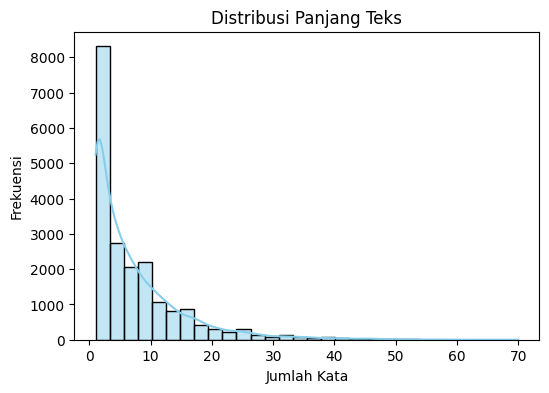

In [540]:
clean_df['text_length'] = clean_df['text_stopword'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(clean_df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

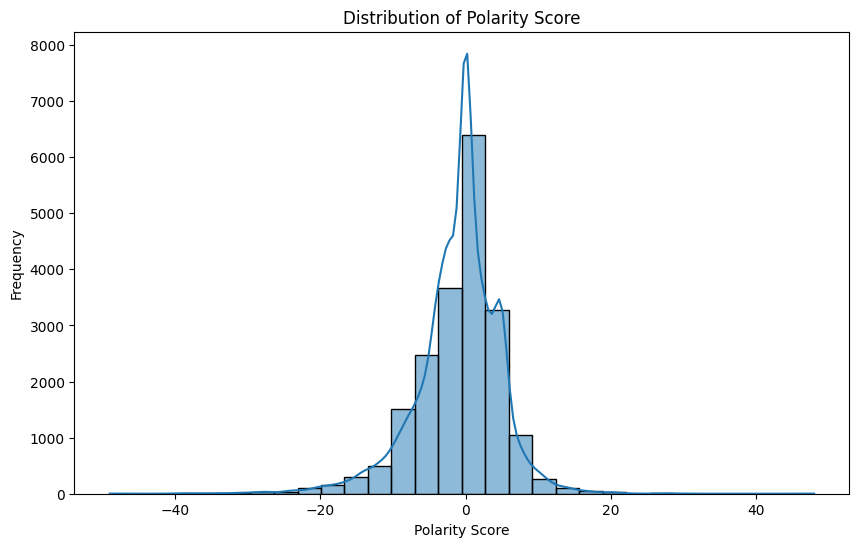

In [541]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

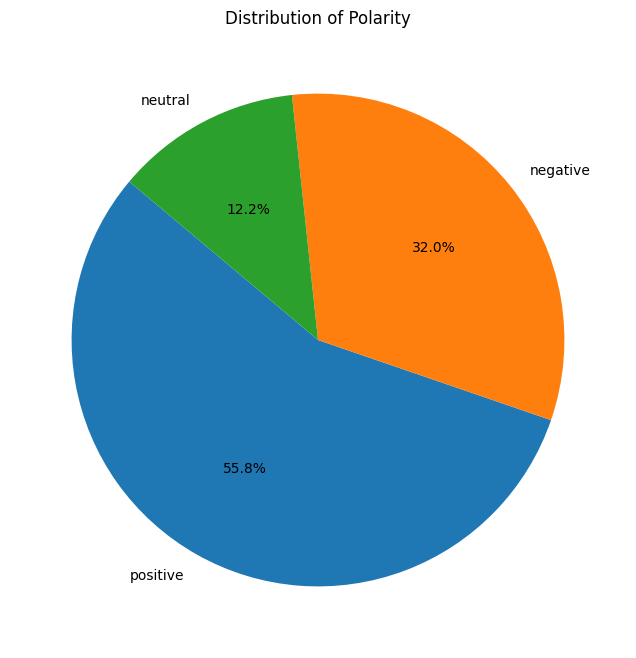

In [542]:
polarity_counts = clean_df['polarity'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

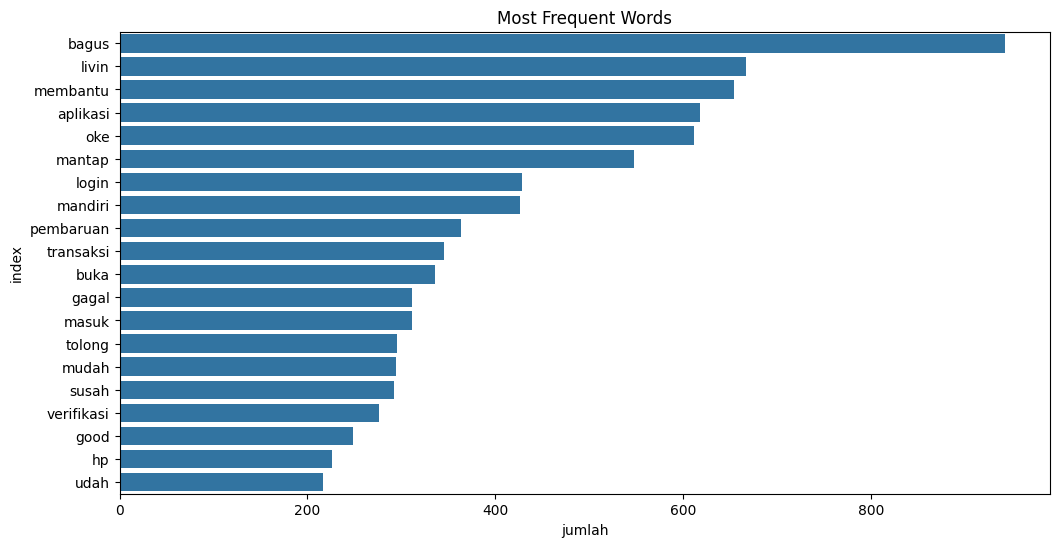

In [543]:
from sklearn.feature_extraction.text import TfidfVectorizer

plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

#Modelling

#1. Naive Bayes Classifier + TF-IDF (Splitting Data 80/20)

In [544]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Inisialisasi dan fit TF-IDF ke kolom 'text_akhir'
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(clean_df['text_akhir'])  # hasil: matriks sparse

le = LabelEncoder()
y = le.fit_transform(clean_df['polarity'])  # hasil: 0, 1, 2

# Mapping label -> angka
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [545]:
from sklearn.model_selection import train_test_split

# Split data dengan stratifikasi agar distribusi label tetap seimbang
X_train_nbc, X_test_nbc, y_train_nbc, y_test_nbc = train_test_split(
    X, y,
    test_size=0.2,         # 20% untuk data uji
    random_state=42,       # agar hasil konsisten
    stratify=y             # menjaga proporsi sentimen tetap sama di train dan test
)

print("Jumlah data latih:", X_train_nbc.shape[0])
print("Jumlah data uji   :", X_test_nbc.shape[0])

Jumlah data latih: 16000
Jumlah data uji   : 4000


In [546]:
from sklearn.naive_bayes import MultinomialNB

# Inisialisasi model
nbc_model = MultinomialNB()

# Latih model
nbc_model.fit(X_train_nbc, y_train_nbc)

MultinomialNB()

In [547]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi data uji
y_pred_nbc = nbc_model.predict(X_test_nbc)

# Evaluasi
print("🔹 Naive Bayes Classifier")
print("Accuracy :", accuracy_score(y_test_nbc, y_pred_nbc))
print("\nClassification Report:")
print(classification_report(y_test_nbc, y_pred_nbc, target_names=le.classes_))

🔹 Naive Bayes Classifier
Accuracy : 0.7955

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.74      0.76      1278
     neutral       0.99      0.27      0.43       488
    positive       0.79      0.94      0.86      2234

    accuracy                           0.80      4000
   macro avg       0.85      0.65      0.68      4000
weighted avg       0.81      0.80      0.78      4000



#2. Logistic Regression + TF-IDF  (Splitting Data 70/30)

In [548]:
# Split ulang untuk Logistic Regression (70% train, 30% test)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print("Jumlah data latih:", X_train_lr.shape[0])
print("Jumlah data uji   :", X_test_lr.shape[0])

Jumlah data latih: 14000
Jumlah data uji   : 6000


In [549]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inisialisasi model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Prediksi
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluasi
print("🔹 Logistic Regression")
print("Accuracy :", accuracy_score(y_test_lr, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr, target_names=le.classes_))

🔹 Logistic Regression
Accuracy : 0.8723333333333333

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1918
     neutral       0.89      0.38      0.53       732
    positive       0.88      0.97      0.92      3350

    accuracy                           0.87      6000
   macro avg       0.88      0.75      0.78      6000
weighted avg       0.87      0.87      0.86      6000



#3. Support Vector Machine + TF-IDF (Splitting Data 60/40)

In [550]:
from sklearn.model_selection import train_test_split

# Split 60% train, 40% test
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)
print("Jumlah data latih:", X_train_svm.shape[0])
print("Jumlah data uji   :", X_test_svm.shape[0])

Jumlah data latih: 12000
Jumlah data uji   : 8000


In [551]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inisialisasi dan training
svm_model = LinearSVC()
svm_model.fit(X_train_svm, y_train_svm)

# Prediksi
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluasi
print("🔹 Support Vector Machine ")
print("Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=le.classes_))

🔹 Support Vector Machine 
Accuracy: 0.882

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.90      0.89      2557
     neutral       0.81      0.40      0.54       976
    positive       0.89      0.97      0.93      4467

    accuracy                           0.88      8000
   macro avg       0.86      0.76      0.79      8000
weighted avg       0.88      0.88      0.87      8000



In [552]:
import pandas as pd

# Hitung akurasi masing-masing
acc_nbc_train = accuracy_score(y_train_nbc, nbc_model.predict(X_train_nbc))
acc_nbc_test = accuracy_score(y_test_nbc, y_pred_nbc)

acc_lr_train = accuracy_score(y_train_lr, lr_model.predict(X_train_lr))
acc_lr_test = accuracy_score(y_test_lr, y_pred_lr)

acc_svm_train = accuracy_score(y_train_svm, svm_model.predict(X_train_svm))
acc_svm_test = accuracy_score(y_test_svm, y_pred_svm)

# Buat dataframe
model_comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM'],
    'Feature Extraction': ['TF-IDF'] * 3,
    'Split Ratio (Train/Test)': ['80/20', '70/30', '60/40'],
    'Train Accuracy': [acc_nbc_train, acc_lr_train, acc_svm_train],
    'Test Accuracy': [acc_nbc_test, acc_lr_test, acc_svm_test]
})

# Tampilkan tabel
from tabulate import tabulate
print(tabulate(model_comparison, headers='keys', tablefmt='github', showindex=False))


| Model               | Feature Extraction   | Split Ratio (Train/Test)   |   Train Accuracy |   Test Accuracy |
|---------------------|----------------------|----------------------------|------------------|-----------------|
| Naive Bayes         | TF-IDF               | 80/20                      |         0.8575   |        0.7955   |
| Logistic Regression | TF-IDF               | 70/30                      |         0.909071 |        0.872333 |
| SVM                 | TF-IDF               | 60/40                      |         0.973667 |        0.882    |


#Inference

In [553]:
def predict_sentiment_all_models(texts, models_dict, vectorizer, label_encoder):
    results = {}

    for model_name, model in models_dict.items():
        preds = []
        for text in texts:
            text_clean = text.lower()
            text_vector = vectorizer.transform([text_clean])
            pred = model.predict(text_vector)
            label = label_encoder.inverse_transform(pred)[0]
            preds.append(label)
        results[model_name] = preds

    return results

In [554]:
# Dictionary model
models = {
    'Naive Bayes': nbc_model,
    'Logistic Regression': lr_model,
    'SVM': svm_model
}

sample_text = [
    "Aplikasinya sangat membantu dan mudah digunakan.",
    "Belum kucoba semua fiturnya, tampaknya biasa saja.",
    "Proses login ribet dan tidak dapat verifikasi."
]
# Prediksi
results = predict_sentiment_all_models(sample_text, models, tfidf, le)

# Membuat DataFrame dari hasil prediksi
df_hasil = pd.DataFrame(results)

# Menambahkan kolom teks aslinya
df_hasil.insert(0, 'Text', sample_text)

# Tampilkan tabel prediksi
print("Hasil Prediksi Sentimen dari Berbagai Model:")

# Styling opsional (hanya jika di Jupyter Notebook)
df_hasil.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

Hasil Prediksi Sentimen dari Berbagai Model:


,Text,Naive Bayes,Logistic Regression,SVM
0,Aplikasinya sangat membantu dan mudah digunakan.,positive,positive,positive
1,"Belum kucoba semua fiturnya, tampaknya biasa saja.",positive,positive,neutral
2,Proses login ribet dan tidak dapat verifikasi.,negative,negative,negative


In [557]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.2.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
